# TP2 - Problema 1

### Grupo 11

Nelson Almeida a95652
<br>
Nuno Costa a97610

Um  programa imperativo pode ser descrito por um modelo do tipo Control Flow Automaton (CFA) como ilustrado no exemplo da imagem a seguir.

Este programa implementa a multiplicação de dois inteiros $\,a,b\,$ , fornecidos como “input”,    e com precisão limitada a $\,n\,$ bits (fornecido como parâmetro do programa). Note-se que
- Existe a possibilidade de alguma das operações do programa produzir um erro de “overflow”. 
- Os nós do grafo representam ações  que actuam sobre os “inputs” do nó e produzem um “output” com as operações indicadas.
- Os ramos do grafo representam ligações que transferem o “output” de um nodo para o “input” do nodo seguinte. Esta transferência é condicionada pela satisfação da condição associada ao ramo.


a. Construa um FOTS usando BitVector de tamanho $n$ que descreva o comportamento deste autómato. Para isso identifique as variáveis do modelo, o estado inicial e a relação de transição.

b. Verifique se$\;$ $\;\mathsf{P}\,\equiv\,(x*y + z = a*b)\;$ $\;$é um invariante deste comportamento.

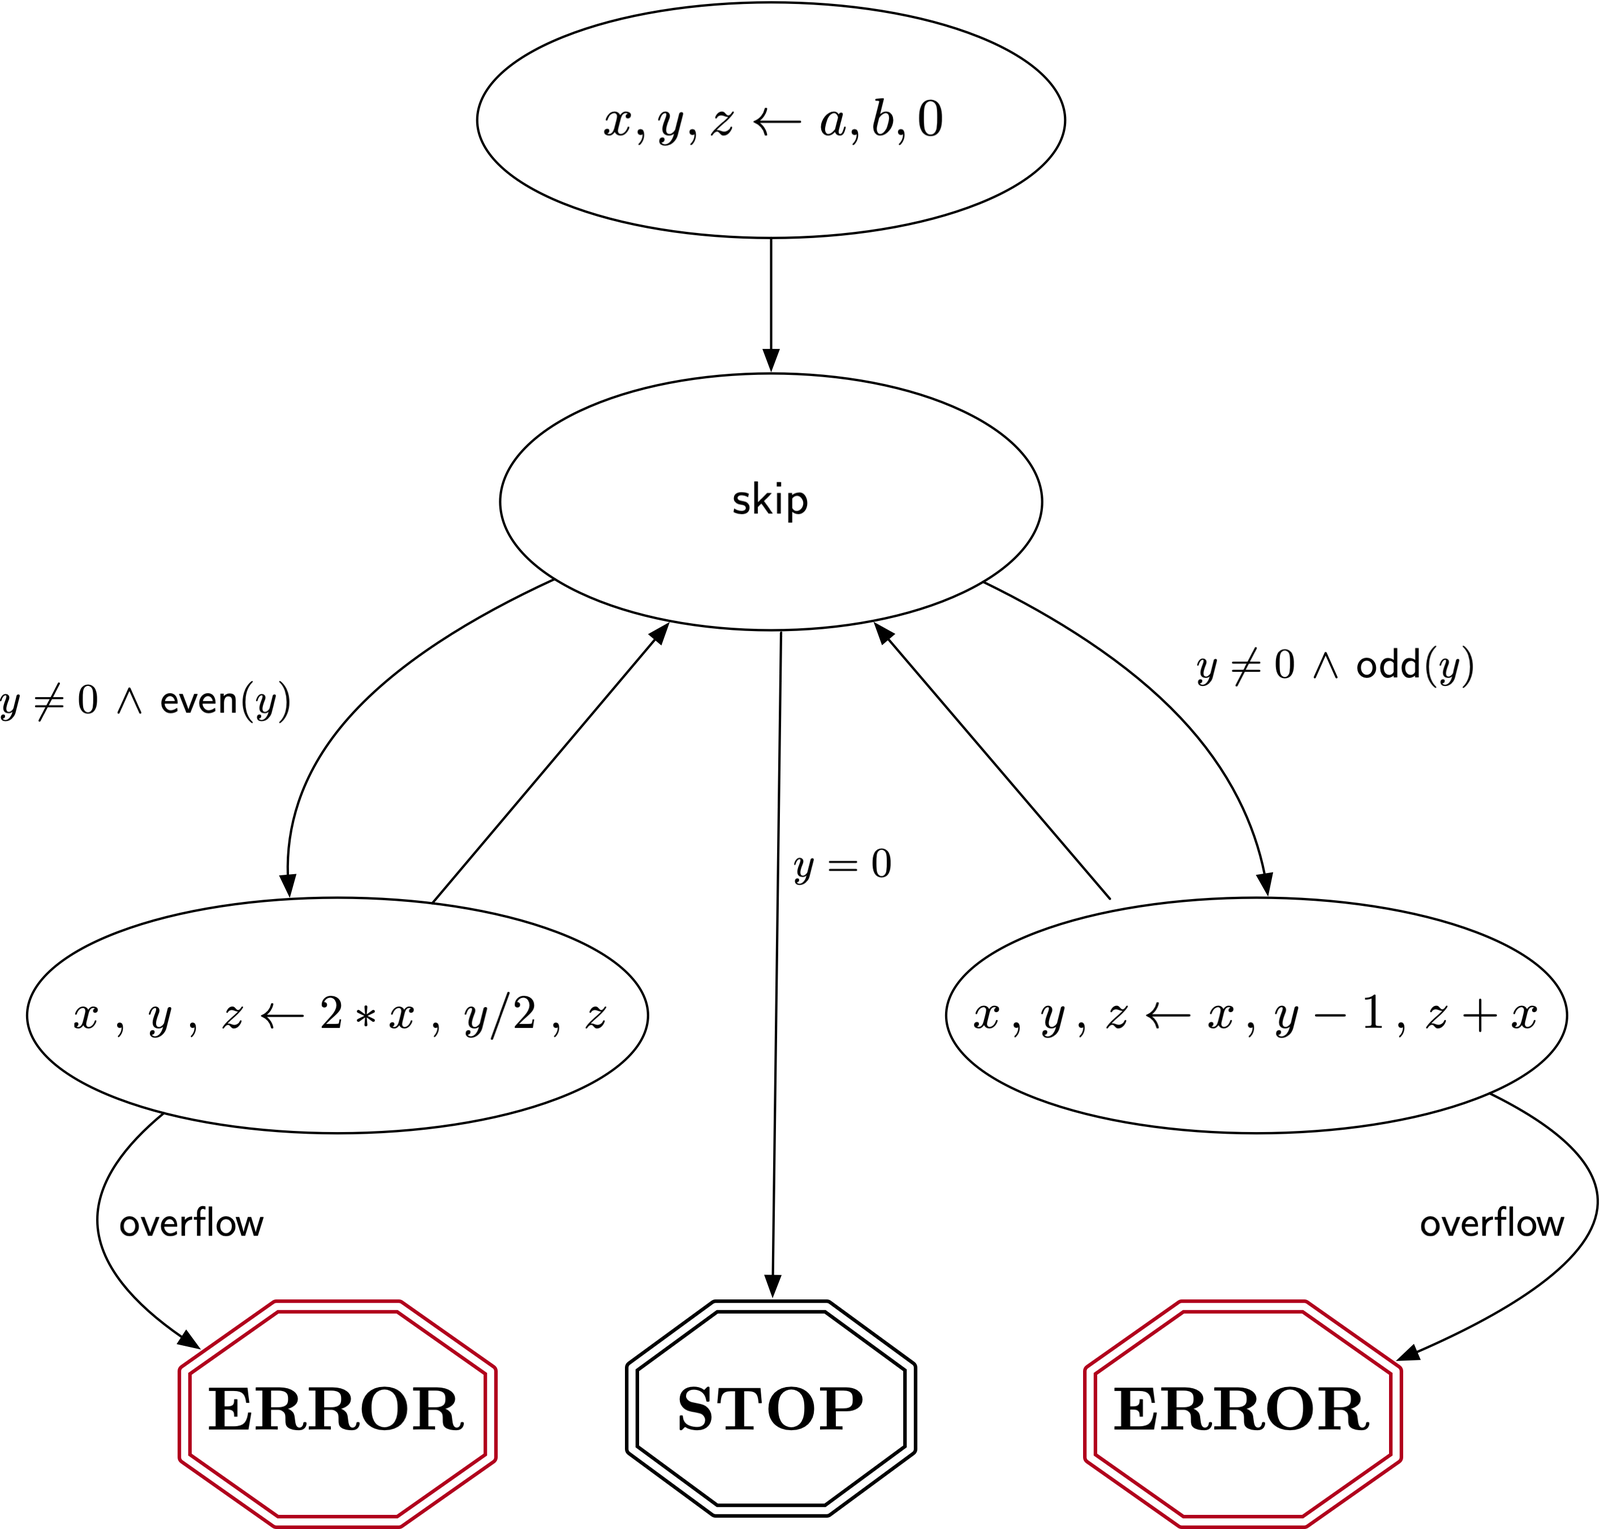

### Inicialização
Começamos por importar o módulo `pysmt.shortcuts` que disponibiliza as funcionalidades para a utilização usual de um SMTsolver. Os tipos estão definidos no módulo `pysmt.typing` de onde temos que importar o tipo INT.

In [51]:
from pysmt.shortcuts import *
from pysmt.typing import INT

### Modelação de predicados
O estado inicial é caracterizado pelo seguinte predicado:

$$ node = 0 \land z = 0 $$

##### Nota: 
Estado atual = node <br> Estado seguinte = node' 

As transições possíveis são caracterizadas pelo seguinte predicado:

$$ node = 0 \land (\,y \neq 0 \land even(y)\,) \land node' = 1 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 0 \land y = 0 \land node' = 2 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 0 \land (\,y \neq 0 \land odd(y)\,) \land node' = 3 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 1 \land node' = 0 \land x' = 2 * x \land y' = y / 2 \land z' = z $$

$$ \lor $$

$$ node = 3 \land node' = 0 \land x' = x \land y' = y - 1 \land z' = z + x $$ 

$$ \lor $$

$$ node = 1 \land node' = 4 \land overflow \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 3 \land node' = 5 \land overflow \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 4 \land node' = 4 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 5 \land node' = 5 \land x' = x \land y' = y \land z' = z $$

$$ \lor $$

$$ node = 2 \land node' = 2 \land x' = x \land y' = y \land z' = z $$

A seguinte função cria a i-ésima cópia das variáveis de estado, agrupadas num dicionário que nos permite aceder às mesmas.

In [52]:
def declare(i, n):
    state = {}
    
    # definir variáveis
    state['node'] = Symbol('node' + str(i), INT)
    state['x'] = Symbol('x' + str(i), BVType(n))
    state['y'] = Symbol('y' + str(i), BVType(n))
    state['z'] = Symbol('z' + str(i), BVType(n))
    
    return state

 Função que testa se esse estado é um possível estado inicial do programa.

In [53]:
def init(state, a, b, n):
    return And(
        Equals(state['node'], Int(0)),
        Equals(state['x'], BV(a,n)),
        Equals(state['y'], BV(b,n)),
        Equals(state['z'], BV(0,n))
    )

Funções auxiliares para determinar se uma variável é par ou impar.

In [54]:
def even(atual, n):
    return Equals(BVURem(atual['y'], BV(2,n)), BV(0,n))

def odd(atual, n):
    return Not(Equals(BVURem(atual['y'], BV(2,n)), BV(0,n)))

Função que dados dois possíveis estados do programa, testa se é possível transitar de um estado para o outro.

In [55]:
def trans(atual, prox, n):
    # 𝑛𝑜𝑑𝑒=0 ∧ ( 𝑦≠0 ∧ 𝑒𝑣𝑒𝑛(𝑦) ) ∧ 𝑛𝑜𝑑𝑒′=1 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t0 = And(
        Equals(atual['node'], Int(0)),
        NotEquals(atual['y'], BV(0,n)),
        even(atual, n),
        Equals(prox['node'], Int(1)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=0 ∧ 𝑦=0 ∧ 𝑛𝑜d𝑒′=2 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t1 = And(
        Equals(atual['node'], Int(0)),
        Equals(atual['y'], BV(0,n)),
        Equals(prox['node'], Int(2)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=0 ∧ ( 𝑦≠0 ∧ 𝑜𝑑𝑑(𝑦) ) ∧ 𝑛𝑜𝑑𝑒′=3 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t2 = And(
        Equals(atual['node'], Int(0)),
        NotEquals(atual['y'], BV(0,n)),
        odd(atual, n),
        Equals(prox['node'], Int(3)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=1 ∧ 𝑛𝑜𝑑𝑒′=0 ∧ 𝑥'=2∗𝑥 ∧ 𝑦'=𝑦/2 ∧ 𝑧'=𝑧
    t3 = And(
        LT(Times(BVToNatural(atual['x']),Int(2)), Pow(Int(2), Int(n))),
        Equals(atual['node'], Int(1)),
        Equals(prox['node'], Int(0)),
        Equals(prox['x'], BVMul(atual['x'], BV(2,n))),
        Equals(prox['y'], BVUDiv(atual['y'], BV(2,n))),
        Equals(prox['z'], atual['z'])
    )

    # 𝑛𝑜𝑑𝑒=3 ∧ 𝑛𝑜𝑑𝑒′=0 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦−1 ∧ 𝑧′=𝑧+𝑥
    t4 = And(
        LT(Plus(BVToNatural(atual['z']), BVToNatural(atual['x'])), Pow(Int(2), Int(n))),
        Equals(atual['node'], Int(3)),
        Equals(prox['node'], Int(0)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], BVSub(atual['y'], BV(1,n))),
        Equals(prox['z'], BVAdd(atual['z'], atual['x']))
    )
      
    # 𝑛𝑜𝑑𝑒=1 ∧ 𝑛𝑜𝑑𝑒′=4 ∧ 𝑜𝑣𝑒𝑟𝑓𝑙𝑜𝑤 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=z
    t5 = And(
        GE(Times(BVToNatural(atual['x']),Int(2)), Pow(Int(2), Int(n))),
        Equals(atual['node'], Int(1)),
        Equals(prox['node'], Int(4)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=3 ∧ 𝑛𝑜𝑑𝑒′=5 ∧ 𝑜𝑣𝑒𝑟𝑓𝑙𝑜𝑤 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t6 = And(
        GE(Plus(BVToNatural(atual['z']), BVToNatural(atual['x'])), Pow(Int(2), Int(n))),
        Equals(atual['node'], Int(3)),
        Equals(prox['node'], Int(5)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=4 ∧ 𝑛𝑜𝑑𝑒′=4 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t7 = And(
        Equals(atual['node'], Int(4)),
        Equals(prox['node'], Int(4)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=5 ∧ 𝑛𝑜𝑑𝑒′=5 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t8 = And(
        Equals(atual['node'], Int(5)),
        Equals(prox['node'], Int(5)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    # 𝑛𝑜𝑑𝑒=2 ∧ 𝑛𝑜𝑑𝑒′=2 ∧ 𝑥′=𝑥 ∧ 𝑦′=𝑦 ∧ 𝑧′=𝑧
    t9 = And(
        Equals(atual['node'], Int(2)),
        Equals(prox['node'], Int(2)),
        Equals(prox['x'], atual['x']),
        Equals(prox['y'], atual['y']),
        Equals(prox['z'], atual['z'])
    )
    
    return Or(t0, t1, t2, t3, t4, t5, t6, t7, t8, t9)

Função que gera um possível traço de execução do programa para k passos.

In [56]:
def gera_traco(declare,init,trans,a_,b_,n_,k_):
    a = a_
    b = b_
    n = n_
    k = k_
    
    #verificar se a e b não são overflow
    if a >= pow(2,n) or b >= pow(2,n): 
        return print("Erro! O valor de 'a' e/ou 'b' não é/são válido(s)!")
    
    with Solver(name="z3") as s:
    
        trace = [declare(i, n) for i in range(k)]
    
        s.add_assertion(init(trace[0], a, b, n))
    
        for i in range(k-1):
            s.add_assertion(trans(trace[i], trace[i+1], n))
    
        if s.solve():
            for i in range(k):
                print("Passo", i)
                for v in trace[i]:
                    print(v, "=", s.get_value(trace[i][v]))
                print("-----------")

Função que testa se o invariante $\;\mathsf{P}\,\equiv\,(x*y + z = a*b)\;$ é válido para os k passos.

In [57]:
def testaInvariante(declare,init,trans,a_,b_,n_,k_):
    a = a_
    b = b_
    n = n_
    k = k_
    
    #verificar se a e b não são overflow
    if a >= pow(2,n) or b >= pow(2,n): 
        return print("Erro! O valor de 'a' e/ou 'b' não é/são válido(s)!")
    
    with Solver(name="z3") as s:
    
        trace = [declare(i, n) for i in range(k+1)]
    
        s.push()
        s.add_assertion(init(trace[0], a, b, n))
    
        for i in range(k):
            s.add_assertion(trans(trace[i], trace[i+1], n))
            
        s.add_assertion(Or([Not(invariante(trace[i], a, b, n)) for i in range(k)]))
    
        if s.solve():
            print("A propriedade do invariante não é válida nos primeiros", k, "passos")
            
            for v in trace[0]:
                print(v, "=", s.get_values([trace[0][v]]))
            return
        
        s.pop()
        s.push()
        
        for i in range(k):
            s.add_assertion(invariante(trace[i], a, b, n))
            s.add_assertion(trans(trace[i], trace[i+1], n))
            
        s.add_assertion(Not(invariante(trace[i], a, b, n)))
        
        if s.solve():
            print("A propriedade do invariante não se verifica")
            
            for v in trace[0]:
                print(v, "=", s.get_value(trace[0][v]))
            return
    
        print("A propriedade do invariante é válida nos", k, "passos")
        
        
def invariante(state,a,b,n):
    return Equals(BVAdd(BVMul(state['x'], state['y']), state['z']), BVMul(BV(a, n), BV(b, n)))

Exemplos:

In [60]:
# a = 5, b = 2, n = 5, k = 10
gera_traco(declare,init,trans,5,2,5,10)
testaInvariante(declare,init,trans,5,2,5,10)

Passo 0
node = 0
x = 5_5
y = 2_5
z = 0_5
-----------
Passo 1
node = 1
x = 5_5
y = 2_5
z = 0_5
-----------
Passo 2
node = 0
x = 10_5
y = 1_5
z = 0_5
-----------
Passo 3
node = 3
x = 10_5
y = 1_5
z = 0_5
-----------
Passo 4
node = 0
x = 10_5
y = 0_5
z = 10_5
-----------
Passo 5
node = 2
x = 10_5
y = 0_5
z = 10_5
-----------
Passo 6
node = 2
x = 10_5
y = 0_5
z = 10_5
-----------
Passo 7
node = 2
x = 10_5
y = 0_5
z = 10_5
-----------
Passo 8
node = 2
x = 10_5
y = 0_5
z = 10_5
-----------
Passo 9
node = 2
x = 10_5
y = 0_5
z = 10_5
-----------
A propriedade do invariante é válida nos 10 passos


In [61]:
# a = 18, b = 4, n = 5, k = 5
gera_traco(declare,init,trans,18,4,5,5)
testaInvariante(declare,init,trans,18,4,5,5)

Passo 0
node = 0
x = 18_5
y = 4_5
z = 0_5
-----------
Passo 1
node = 1
x = 18_5
y = 4_5
z = 0_5
-----------
Passo 2
node = 4
x = 18_5
y = 4_5
z = 0_5
-----------
Passo 3
node = 4
x = 18_5
y = 4_5
z = 0_5
-----------
Passo 4
node = 4
x = 18_5
y = 4_5
z = 0_5
-----------
A propriedade do invariante é válida nos 5 passos


In [62]:
# a = 32, b = 4, n = 5, k = 5
gera_traco(declare,init,trans,32,4,5,5)
testaInvariante(declare,init,trans,32,4,5,5)

Erro! O valor de 'a' e/ou 'b' não é/são válido(s)!
Erro! O valor de 'a' e/ou 'b' não é/são válido(s)!


No exemplo anterior ocrorreu erro, porque para n = 5 bits é impossivél representar a = 32 (overflow). 

In [63]:
gera_traco(declare,init,trans,2,1,5,10)

Passo 0
node = 0
x = 2_5
y = 1_5
z = 0_5
-----------
Passo 1
node = 3
x = 2_5
y = 1_5
z = 0_5
-----------
Passo 2
node = 0
x = 2_5
y = 0_5
z = 2_5
-----------
Passo 3
node = 2
x = 2_5
y = 0_5
z = 2_5
-----------
Passo 4
node = 2
x = 2_5
y = 0_5
z = 2_5
-----------
Passo 5
node = 2
x = 2_5
y = 0_5
z = 2_5
-----------
Passo 6
node = 2
x = 2_5
y = 0_5
z = 2_5
-----------
Passo 7
node = 2
x = 2_5
y = 0_5
z = 2_5
-----------
Passo 8
node = 2
x = 2_5
y = 0_5
z = 2_5
-----------
Passo 9
node = 2
x = 2_5
y = 0_5
z = 2_5
-----------
